In [149]:
import tensorflow as tf
import numpy as np
import sys
from sklearn.preprocessing import normalize
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import style


In [21]:
xy = np.loadtxt('C:\\Users\\SANHA\\Desktop\\new_data.csv', delimiter=',', dtype=np.float32)
x_data=xy[:,0:-1]
x_data = normalize(x_data, axis=0, norm='max')
xy[:,0:-1]=x_data
y_data=xy[:,[-1]]
m_data=xy[:499,:]
r_data=xy[:10000,:]
g_data=xy[:0,:]
F_data=xy[:,:]

In [3]:
# Model Inputs
def model_inputs(real_dim, noise_dim):
    inputs_real_ = tf.placeholder(tf.float32, shape=[None, real_dim], name='inputs_real')
    inputs_z_ = tf.placeholder(tf.float32, shape=[None, noise_dim], name='inputs_z')
    
    return inputs_real_, inputs_z_

def leaky_relu(x, alpha):
    return tf.maximum(alpha * x, x)

In [4]:
# Generator Network
def model_generator(z_input, out_dim, n_units=128, reuse=False, alpha=0.01):
    # used to reuse variables, name scope
    with tf.variable_scope('generator', reuse=reuse):
        hidden_layer = tf.layers.dense(z_input, n_units, activation=None)
        hidden_layer = leaky_relu(hidden_layer, alpha)
        
        logits = tf.layers.dense(hidden_layer, out_dim, activation=None)
        outputs = tf.nn.sigmoid(logits)
        
        return outputs, logits

In [5]:
# Discriminator Network
def model_discriminator(input, n_units=128, reuse=False, alpha=0.1):
    with tf.variable_scope('discriminator', reuse=reuse):
        hidden_layer = tf.layers.dense(input, n_units, activation=tf.nn.relu)
        #hidden_layer = leaky_relu(hidden_layer, alpha)
        
        logits = tf.layers.dense(hidden_layer, 1, activation=None)
        outputs = tf.nn.sigmoid(logits)
        
        return outputs, logits

In [6]:
#parameter
input_size = 42
z_dim = 21
g_hidden_size = 128
d_hidden_size = 128
alpha = 0.1
smooth = 0.1
learning_rate = 0.001

In [9]:
tf.reset_default_graph()  # If we don't have this, as we call this block over and over, the graph gets bigger and bigger

graph = tf.Graph()
with graph.as_default():
    inputs_real, inputs_z = model_inputs(input_size, z_dim)
    
    g_outputs, g_logits = model_generator(inputs_z, input_size, n_units=g_hidden_size, reuse=False, alpha=alpha)
    
    d_outputs_real, d_logits_real = model_discriminator(inputs_real, n_units=d_hidden_size, reuse=False, alpha=alpha)
    d_outputs_fake, d_logits_fake = model_discriminator(g_outputs, n_units=d_hidden_size, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    t_vars = tf.trainable_variables()
    g_vars = [variable for variable in t_vars if 'generator' in variable.name]
    d_vars = [variable for variable in t_vars if 'discriminator' in variable.name]
    
    # Affected Variables with var_list
    d_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(d_loss, var_list=d_vars)
    g_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(g_loss, var_list=g_vars)
    
    # Saving variables with var_list
    saver = tf.train.Saver(var_list=g_vars)

In [7]:
plt.plot(list_loss_g,list_loss_d)

NameError: name 'list_loss_g' is not defined

In [8]:
list_loss_d

NameError: name 'list_loss_d' is not defined

In [ ]:
list_loss_g

In [11]:
samples=[]
normal=0
abnormal=0
list_loss_d=[]
list_loss_g=[]
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    f = open('C:\\Users\\SANHA\\Desktop\\gen_sample100000.txt', 'a+')
    for step in range(100000):
        
        
        batch_images = F_data[step].reshape([1, 42])
        batch_z = np.random.uniform(-1, 1, size=[1, z_dim])
        
        _ = sess.run(d_optimizer, feed_dict={inputs_real : batch_images, inputs_z : batch_z})
        _ = sess.run(g_optimizer, feed_dict={inputs_z : batch_z})
        loss_d, loss_g = sess.run([d_loss, g_loss], feed_dict={inputs_real : batch_images, inputs_z : batch_z})
        list_loss_d.append(loss_d)
        list_loss_g.append(loss_g)
        #if step%1000==0:
        #    print('step {} / {} Complete. D_Loss : {:0.3f}, G_Loss : {:0.3f}'.format(step+1, 100000, loss_d, loss_g))
        sys.stdout.write("\r%d / %d: %f, %f" % (step, 100000, loss_d, loss_g))
        sys.stdout.flush()
        sample_z = np.random.uniform(-1, 1, size=[1, z_dim])  # 16 Samples each epoch
        gen_samples, _ = sess.run(model_generator(inputs_z, input_size, reuse=True), feed_dict={inputs_z : sample_z})
        
        temp=gen_samples[0,41]
        #print(temp)
        if temp>=0.5:
            gen_samples[0,41]=1
            abnormal+=1
        else :
            gen_samples[0,41]=0
            normal+=1
        #print(temp,gen_samples[0,41])
        #write for text to csv
        f.write("%f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f \n" %(gen_samples[0,0],gen_samples[0,1],gen_samples[0,2],gen_samples[0,3],gen_samples[0,4],gen_samples[0,5],gen_samples[0,6],gen_samples[0,7],gen_samples[0,8],gen_samples[0,9],gen_samples[0,10],gen_samples[0,11],gen_samples[0,12],gen_samples[0,13],gen_samples[0,14],gen_samples[0,15],gen_samples[0,16],gen_samples[0,17],gen_samples[0,18],gen_samples[0,19],gen_samples[0,20],gen_samples[0,21],gen_samples[0,22],gen_samples[0,23],gen_samples[0,24],gen_samples[0,25],gen_samples[0,26],gen_samples[0,27],gen_samples[0,28],gen_samples[0,29],gen_samples[0,30],gen_samples[0,31],gen_samples[0,32],gen_samples[0,33],gen_samples[0,34],gen_samples[0,35],gen_samples[0,36],gen_samples[0,37],gen_samples[0,38],gen_samples[0,39],gen_samples[0,40],gen_samples[0,41]))
       
        
    print('Generating Complete. normal={}, abnormal={}'.format(normal,abnormal))
    f.close()

28488 / 100000: 0.697456, 1.169728

KeyboardInterrupt: 

In [20]:
xy2 = np.genfromtxt('C:\\Users\\SANHA\\Desktop\\mix_data_40000.csv', delimiter=',', dtype=np.float32)
xy3 = np.loadtxt('C:\\Users\\SANHA\\Desktop\\gen_data.csv', delimiter=',', dtype=np.float32)
xy4 = np.loadtxt('C:\\Users\\SANHA\\Desktop\\false_data.csv', delimiter=',', dtype=np.float32)
#gen data 20000
gx_data=xy3[:,0:-1]
gy_data=xy3[:,[-1]]
gF_data=xy3[:,:]

#gen 20000+real 20000
mx_data=xy2[:39999,0:-1]
my_data=xy2[:39999,[-1]]
mF_data=xy2[:39999,:]

#real data 40000
tx_data=r_data[:40000,0:-1]
ty_data=r_data[:40000,[-1]]

#false data
FF_data=xy4[:,:]
Fx_data=xy4[:,0:-1]
Fy_data=xy4[:,[-1]]
print("finished")

finished


step:     0	Loss: 2.352	Acc: 46.54%
step:    10	Loss: 0.349	Acc: 87.93%
step:    20	Loss: 0.227	Acc: 89.01%
step:    30	Loss: 0.176	Acc: 92.19%
step:    40	Loss: 0.150	Acc: 94.74%
step:    50	Loss: 0.135	Acc: 95.40%
step:    60	Loss: 0.125	Acc: 96.00%
step:    70	Loss: 0.119	Acc: 96.06%
step:    80	Loss: 0.113	Acc: 96.42%
step:    90	Loss: 0.109	Acc: 96.53%
0
100
200
300
400
500
600
700
800


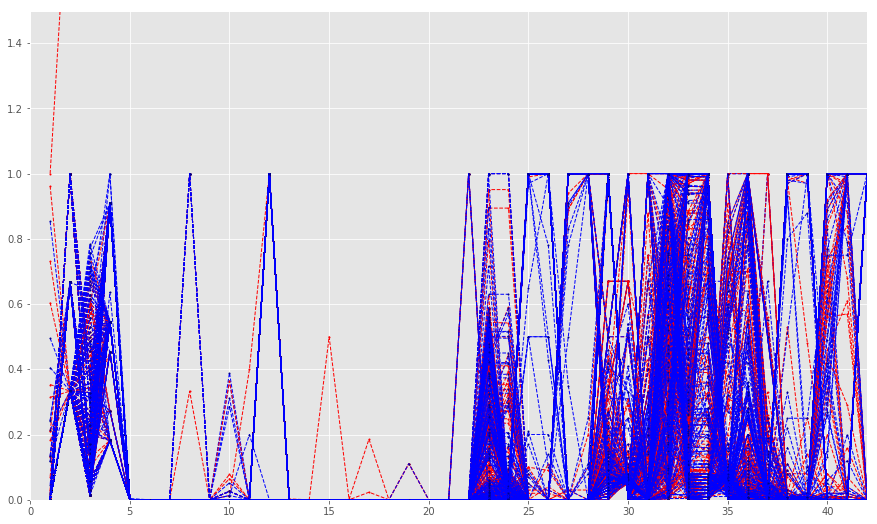

true=431 false: 387 acc: 0.53


In [390]:
nb_classes=2

X=tf.placeholder(tf.float32,[None,41])
Y=tf.placeholder(tf.int32,[None,1])

Y_one_hot=tf.one_hot(Y,nb_classes)
Y_one_hot=tf.reshape(Y_one_hot,[-1,nb_classes])

W1=tf.Variable(tf.random_normal([41,41]),name='weight1')
b1=tf.Variable(tf.random_normal([41]),name='bias1')
layer1=tf.sigmoid(tf.matmul(X,W1)+b1)

W2=tf.Variable(tf.random_normal([41,41]),name='weight2')
b2=tf.Variable(tf.random_normal([41]),name='bias2')
layer2=tf.sigmoid(tf.matmul(layer1,W2)+b2)

W3=tf.Variable(tf.random_normal([41,nb_classes]),name='weight3')
b3=tf.Variable(tf.random_normal([nb_classes]),name='bias3')
logits=tf.matmul(layer2,W3)+b3
hypothesis=tf.nn.softmax(logits)

cost_i=tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=Y_one_hot)

cost=tf.reduce_mean(cost_i)
optimizer=tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)

prediction=tf.argmax(hypothesis,1) #가능성을 퍼센트로~~
correct_prediction=tf.equal(prediction,tf.arg_max(Y_one_hot,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #f = open('C:\\Users\\SANHA\\Desktop\\false_data.txt', 'w')
    for step in range(100):
        sess.run(optimizer,feed_dict={X:x_data,Y:y_data})
        #print("training by gan sample")
        if step %10==0:
            loss,acc=sess.run([cost,accuracy],feed_dict={X:x_data,Y:y_data})
            print("step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step,loss,acc))


#m_data=np.append(m_data,gen_samples,axis=0)

    pred = sess.run(prediction, feed_dict={X: Fx_data})
    tr=0
    fa=0
    total=0
    fig = plt.figure(figsize=(15,9))
    ax = fig.add_subplot(1,1,1)
    ax.set(xlim=[0, 42], ylim=[0,1.5])
    for p, y in zip(pred, Fy_data.flatten()):
            if(total%100==0):
                print(total)
            if(p==int(y)): 
                tr+=1
                total+=1
            #if(tr%50==0):
                line, = ax.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42], F_data[total,:].flatten())
                line.set(color='red',
                 linewidth=1, linestyle='--',
                 marker='o', markersize=1, markeredgewidth=1,
                 markerfacecolor='blue', markeredgecolor='darkblue')
            else:
                fa+=1
                total+=1
                line, = ax.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42], F_data[total,:].flatten())
                line.set(color='green',
                 linewidth=1, linestyle='--',
                 marker='o', markersize=1, markeredgewidth=1,
                 markerfacecolor='green', markeredgecolor='green')
                


    plt.show()                          
   
    #f.close()
    print("true={} false: {} acc: {:0.2f}".format(tr,fa,tr/(tr+fa)))

In [171]:
with tf.Session() as sess:  
    pred = sess.run(prediction, feed_dict={X: x_data})
    for p, y in zip(pred, y_data.flatten()):
            if(p==int(y)):
                tr=tr+1
            else:
                fa=fa+1
                #print(gx_data)
                f.write("%f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f \n" %(gx_data[fa,0],gx_data[fa,1],gx_data[fa,2],gx_data[fa,3],gx_data[fa,4],gx_data[fa,5],gx_data[fa,6],gx_data[fa,7],gx_data[fa,8],gx_data[fa,9],gx_data[fa,10],gx_data[0,11],gx_data[fa,12],gx_data[fa,13],gx_data[fa,14],gx_data[fa,15],gx_data[fa,16],gx_data[fa,17],gx_data[fa,18],gx_data[fa,19],gx_data[fa,20],gx_data[fa,21],gx_data[fa,22],gx_data[fa,23],gx_data[fa,24],gx_data[fa,25],gx_data[fa,26],gx_data[fa,27],gx_data[fa,28],gx_data[fa,29],gx_data[fa,30],gx_data[fa,31],gx_data[fa,32],gx_data[fa,33],gx_data[fa,34],gx_data[fa,35],gx_data[fa,36],gx_data[fa,37],gx_data[fa,38],gx_data[fa,39],gx_data[fa,40],gy_data[fa,0]))
                
            #print("[{}] Prediction: {} Real Y: {}".format(p == int(y), p, int(y)))

FailedPreconditionError: Attempting to use uninitialized value weight1_34
	 [[Node: weight1_34/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](weight1_34)]]

Caused by op 'weight1_34/read', defined at:
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\asyncio\base_events.py", line 1425, in _run_once
    handle._run()
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\asyncio\events.py", line 127, in _run
    self._callback(*self._args)
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-170-2e6f997294bc>", line 10, in <module>
    W1=tf.Variable(tf.random_normal([41,41]),name='weight1')
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\tensorflow\python\ops\variables.py", line 259, in __init__
    constraint=constraint)
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\tensorflow\python\ops\variables.py", line 422, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\tensorflow\python\ops\array_ops.py", line 79, in identity
    return gen_array_ops.identity(input, name=name)
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 3887, in identity
    "Identity", input=input, name=name)
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\tensorflow\python\framework\ops.py", line 3414, in create_op
    op_def=op_def)
  File "C:\Users\SANHA\Anaconda3\envs\py35\lib\site-packages\tensorflow\python\framework\ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value weight1_34
	 [[Node: weight1_34/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](weight1_34)]]


0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
0.0
0.6666667
0.028571429
0.90909094
1.0579987e-07
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.025440313
0.0019569471
0.0
0.0
0.0
0.0
0.08
0.15
0.0
1.0
0.003921569
0.0
0.6
0.88
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.33333334
0.042857144
0.54545456
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.2407045
0.011741683
1.0
1.0
0.0
0.0
0.05
0.07
0.0
1.0
0.101960786
0.1
0.05
0.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
0.33333334
0.057142857
0.90909094
1.6812034e-07
6.2239615e-06
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.009784736
0.009784736
0.2
0.2
0.0
0.0
1.0
0.0
0.0
0.11764706
1.0
1.0
0.0
0.03
0.04
0.03
0.01
0.0
0.01
0.0
0.0
0.33333334
0.057142857
0.90909094
1.4420667e-07
3.2062601e-07
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

TypeError: only size-1 arrays can be converted to Python scalars

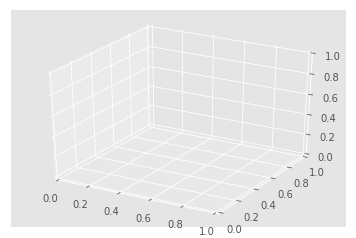

In [361]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
graph=F_data[:100,:]
#data=[]
epoch=np.linspace(1,10,10)
feature=np.linspace(0,41,42)
F,E=np.meshgrid(feature,epoch)

for a in range(10):
    #print(a)
    for b in range(41+1):
        #print(E[a][a]-1,F[a][b])
        data=np.array(F_data[int(E[a][a]-1),int(F[a][b])])
        print(F_data[int(E[a][a]-1),int(F[a][b])])
        
#print(F.flatten())

#print(F_data[E.flatten(),F.flatten()])


print("-------")
fig=plt.figure()
ax=fig.gca(projection='3d')

Xi=F.flatten()
Yi=E.flatten()
Zi=np.zeros(1)

dx=.05*np.ones(1)
dy=.05*np.ones(1)
dz=data.flatten()
print(F_data[int(E[int(Yi)][int(Xi)]-1),int(F[int(Yi)][int(Xi)])])

ax.bar3d(Xi,Yi,Zi,dx,dy,dz,color='r')

plt.show()

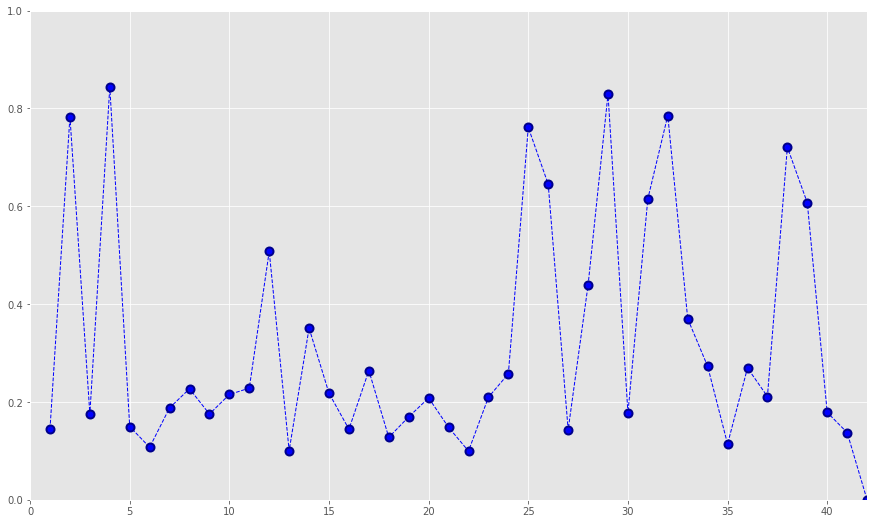

In [174]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.set(xlim=[0, 42], ylim=[0,1])
 
line, = ax.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42], FF_data[99:100,:].flatten())
if(FF_data[99:100,[-1]]==0):
    line.set(color='blue',
         linewidth=1, linestyle='--',
         marker='o', markersize=8, markeredgewidth=2,
         markerfacecolor='blue', markeredgecolor='darkblue')
else:
    line.set(color='red',
         linewidth=1, linestyle='--',
         marker='o', markersize=8, markeredgewidth=2,
         markerfacecolor='blue', markeredgecolor='darkred')
 
plt.show()

